In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import torch.utils.data as data
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange
import copy

C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data.csv', delimiter=",")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
df_eval = pd.read_csv('evaluation_data.csv', delimiter=",")
df_eval.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-20,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881
1,2011-01-20,1,0,1,1,0,4,1,1,0.26,0.2727,0.56,0.0000
2,2011-01-20,1,0,1,2,0,4,1,1,0.26,0.2727,0.56,0.0000
3,2011-01-20,1,0,1,3,0,4,1,1,0.26,0.2576,0.56,0.1642
4,2011-01-20,1,0,1,4,0,4,1,1,0.26,0.2576,0.56,0.1642


In [4]:
df_cas = df.drop(columns=['dteday', 'cnt', 'registered', 'instant']).astype(float)
df_reg = df.drop(columns=['dteday', 'cnt', 'casual', 'instant']).astype(float)
test = df_eval.drop(columns=['dteday']).astype(float)

In [5]:
train_cas = df_cas.iloc[:9500]
val_cas = df_cas.iloc[9500:]

train_reg = df_reg.iloc[:9500]
val_reg = df_reg.iloc[9500:]

In [6]:
X_train_cas, y_train_cas = train_cas.drop('casual', axis=1), train_cas['casual']
print(X_train_cas.shape)

X_val_cas, y_val_cas = val_cas.drop('casual', axis=1), val_cas['casual']
print(X_val_cas.shape)

X_train_reg, y_train_reg = train_reg.drop('registered', axis=1), train_reg['registered']
print(X_train_reg.shape)

X_val_reg, y_val_reg = val_reg.drop('registered', axis=1), val_reg['registered']
print(X_val_reg.shape)

X_test = test
print(X_test.shape)

(9500, 12)
(1386, 12)
(9500, 12)
(1386, 12)
(6493, 12)


In [7]:
f = 20 # no. of batches

train_batch_reg = np.array_split(X_train_reg, f) 
label_batch_reg = np.array_split(y_train_reg, f) # 50 sections/batches

val_batch_reg = np.array_split(X_val_reg, f)
val_label_batch_reg = np.array_split(y_val_reg, f)

train_batch_cas = np.array_split(X_train_cas, f) 
label_batch_cas = np.array_split(y_train_cas, f) # 50 sections/batches

val_batch_cas = np.array_split(X_val_cas, f)
val_label_batch_cas = np.array_split(y_val_cas, f)

test_batch = np.array_split(X_test,f) 
# test_label_batch  = np.array_split(y_test, f)


for i in range(len(train_batch_cas)):
    train_batch_cas[i] = torch.from_numpy(train_batch_cas[i].values).float()
for i in range(len(label_batch_cas)):
    label_batch_cas[i] = torch.from_numpy(label_batch_cas[i].values).float().view(-1, 1)
    
for i in range(len(val_batch_cas)):
    val_batch_cas[i] = torch.from_numpy(val_batch_cas[i].values).float()
for i in range(len(val_label_batch_cas)):
    val_label_batch_cas[i] = torch.from_numpy(val_label_batch_cas[i].values).float().view(-1, 1)
    
    
for i in range(len(train_batch_reg)):
    train_batch_reg[i] = torch.from_numpy(train_batch_reg[i].values).float()
for i in range(len(label_batch_reg)):
    label_batch_reg[i] = torch.from_numpy(label_batch_reg[i].values).float().view(-1, 1)
    
for i in range(len(val_batch_reg)):
    val_batch_reg[i] = torch.from_numpy(val_batch_reg[i].values).float()
for i in range(len(val_label_batch_reg)):
    val_label_batch_reg[i] = torch.from_numpy(val_label_batch_reg[i].values).float().view(-1, 1)
    
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
# for i in range(len(test_label_batch)):
#     test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
print("Batch size:", len(train_batch_reg[0]))


Batch size: 475


In [8]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(12, 24)
        self.fc8 = nn.Linear(24, 1)

        self.dropout = nn.Dropout(0.20)
       
    def forward(self, x):
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc3(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc4(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc5(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc6(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc7(x))
        x = self.dropout(x)
        x = F.relu(self.fc8(x))

        return x

In [9]:
def get_trained_model(train_batch, label_batch, val_batch, val_label_batch):
    model = Regressor()
    train_losses, val_losses = [], []
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001) # 0.015 87
    total_epochs=0
    
    best_model = copy.deepcopy(model)
    best_val_loss = None
    
    #print(model)
    epochs = 400
    total_epochs+=epochs

    model.train()

    for e in range(epochs):

        train_loss = 0
        val_loss_1 = 0
        val_loss_sum = 0

        for i in range(len(train_batch)):

            output = model(train_batch[i])
            loss = criterion(output, label_batch[i])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            with torch.no_grad():

                for j in range(len(val_batch)):

                    val_output = model(val_batch[j])
                    val_loss =  criterion(val_output, val_label_batch[j])
                    val_loss_1+=val_loss.item()
            val_loss_sum=val_loss_1/len(val_batch)

        # saving best model
        val_loss_divided = val_loss_sum/len(val_batch)
        if best_val_loss is None or val_loss_divided < best_val_loss:
            best_val_loss = val_loss_divided
            best_model = copy.deepcopy(model)


        val_losses.append(val_loss_divided)    
        train_losses.append(train_loss/len(train_batch))

        if e % 10 == 0:
            print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_divided)
            
        
    return model, train_losses, val_losses

In [10]:
model_cas, train_losses_cas, val_losses_cas = get_trained_model(train_batch_cas, label_batch_cas, val_batch_cas, val_label_batch_cas)

Epoch : 0 train_loss : 3829.3236696243284 Val loss:  3264.1559822845456
Epoch : 10 train_loss : 3747.125127983093 Val loss:  3183.7049279022217
Epoch : 20 train_loss : 3663.7122774124146 Val loss:  3097.7799449157715
Epoch : 30 train_loss : 3566.1469305038454 Val loss:  3000.0960373687744
Epoch : 40 train_loss : 3443.8312606811523 Val loss:  2872.9207802963256
Epoch : 50 train_loss : 3298.3344881057737 Val loss:  2736.711076507568
Epoch : 60 train_loss : 3156.693404006958 Val loss:  2598.43871711731
Epoch : 70 train_loss : 3012.2664501190184 Val loss:  2470.70000869751
Epoch : 80 train_loss : 2880.2875606536863 Val loss:  2367.9959120559693
Epoch : 90 train_loss : 2765.25065536499 Val loss:  2282.574557762146
Epoch : 100 train_loss : 2677.0295265197756 Val loss:  2224.0589910888675
Epoch : 110 train_loss : 2600.9976547241213 Val loss:  2176.114684906006
Epoch : 120 train_loss : 2537.2487930297852 Val loss:  2175.9042668151856
Epoch : 130 train_loss : 2508.5339691162108 Val loss:  2173.

In [11]:
model_reg, train_losses_reg, val_losses_reg = get_trained_model(train_batch_reg, label_batch_reg, val_batch_reg, val_label_batch_reg)

Epoch : 0 train_loss : 42341.9400390625 Val loss:  77100.87583007812
Epoch : 10 train_loss : 41971.859545898435 Val loss:  76489.79079101564
Epoch : 20 train_loss : 41449.961254882815 Val loss:  75608.46975585938
Epoch : 30 train_loss : 40746.74428710937 Val loss:  74458.28014648438
Epoch : 40 train_loss : 39880.673815917966 Val loss:  72928.37540039062
Epoch : 50 train_loss : 38847.7419921875 Val loss:  71071.09142578125
Epoch : 60 train_loss : 37549.22795410156 Val loss:  68953.94562500001
Epoch : 70 train_loss : 36276.49490966797 Val loss:  66605.75209960938
Epoch : 80 train_loss : 34822.12827148438 Val loss:  64153.5408203125
Epoch : 90 train_loss : 33390.218359375 Val loss:  61640.62180664062
Epoch : 100 train_loss : 32039.59158935547 Val loss:  59035.13870117187
Epoch : 110 train_loss : 30536.990014648436 Val loss:  56417.07543457032
Epoch : 120 train_loss : 29073.150732421876 Val loss:  53936.73512207031
Epoch : 130 train_loss : 27717.220812988282 Val loss:  51427.31558105469
Ep

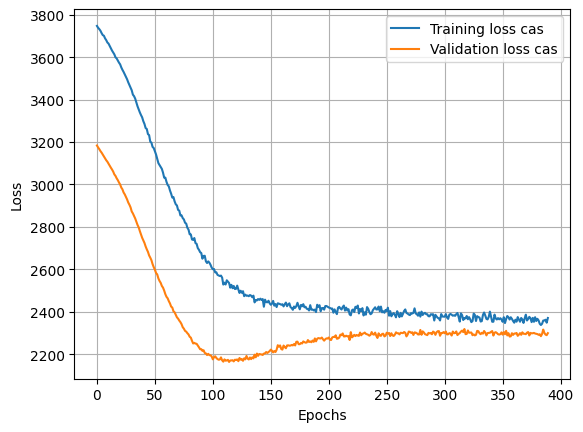

In [12]:
frm = 10 # does not 
plt.plot(train_losses_cas[frm:], label='Training loss cas')
plt.plot(val_losses_cas[frm:], label='Validation loss cas')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

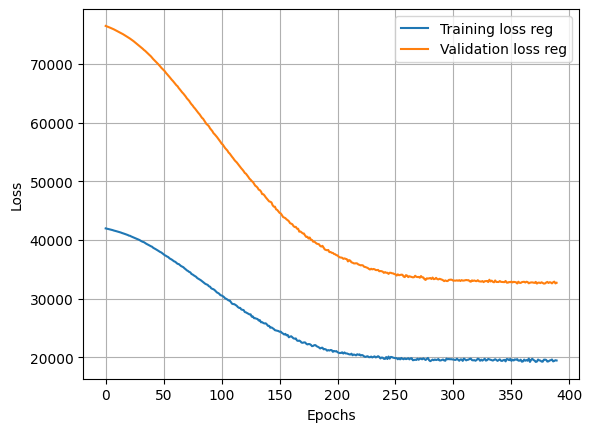

In [13]:
frm = 10 # does not 
plt.plot(train_losses_reg[frm:], label='Training loss reg')
plt.plot(val_losses_reg[frm:], label='Validation loss reg')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

In [14]:
def predict(model, test_batch):
    # predicting for every batch
    test_outputs = []
    for j in range(len(test_batch)):
        test_output = model(test_batch[j])
        for value in test_output:
            test_outputs.append(value)
            
    # tensor to list
    list_output = []
    for output in test_outputs:
        list_output.append(output.item())
    
    # list to dataframe
    df_output = pd.DataFrame(list_output)
    
    return df_output

In [15]:
preds_cas = predict(model_cas, test_batch)

In [16]:
preds_cas.describe()

,0
count,6493.000000
mean,36.174592
std,15.452445
min,4.788384
25%,24.609697
50%,34.720665
75%,46.676205
max,92.096695


In [17]:
preds_reg = predict(model_reg, test_batch)

In [18]:
df_output = preds_cas + preds_reg

In [19]:
# saving to file
df_output.to_csv('muchomorki.csv', header=False, index=False)

In [20]:
df_output.describe()

,0
count,6493.000000
mean,179.248874
std,68.146920
min,24.797099
25%,127.107773
50%,173.257889
75%,227.531898
max,411.511475
